# <center> Group Project Sub 02 - FEATURE SELECTION AND ENGINEERING </center>

## AUTHORS:
### David Kwasi Nyonyo Mensah-Gbekor (mensah-gbekor@hotmail.com)
### David Wonder Doe-Dekpey (wonderdoe85@yahoo.com)
### Alexander Botica (alexbotica@yahoo.com)
### Alexander Victor Okhuese (alexandervictor16@yahoo.com)

### 
###   

# TASKS

1. Select at least four (4) explanatory variables and perform the necessary transformations so that they are useful in the model phase. You are encouraged to use more than four variables. Investigate feature engnineering techniques such as PCA and encoding target variables using one-hot encoding.

2. Write a short paragraph about each technique investigated and show an implementation of it in a Jupyter Notebook. Make sure to include references that indicate where the ideas were sourced.

3. At this stage groups should take the opportunity to familiarize themselves with the cross-validation tecniques for forecasting time series - for example, traditional k-fold cross-validation versus wald forward analysis, and Purged K-Fold CV. Write a short paragraph explaining each technique researched. Research at least three (they don't have to be the 3 mentioned here).


# Solutions

We first import the necessary python modules

In [2]:
%matplotlib inline

In [3]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.model_selection import train_test_split
from sklearn import svm

Function needed

In [4]:
def retrieve_data(symbol, api_key):
    """    Parameters
    symbol - The stock's symbol
    api_key - The free API key obtained from alpha vantage
    """
    
    ts = TimeSeries(key=api_key, output_format='pandas')
    close, _ = ts.get_daily_adjusted(symbol=symbol, outputsize='full')
    return close

## Main Section of Code

Below we use historical data downloaded from Alpha Vantage using pandas_datareader<br/>
We use data of the following tickers
1. NASDAQ100 - Target Variable
2. S&P500
3. NAS30(Dow Jones)

In [5]:
nas_100 = 'NDX'
sp_500 = 'SPX'
us_30 = '.DJI'

#API_KEY = os.getenv('ALPHAVANTAGE_API_KEY')  # Our API Key, retrieved form the environment variables
API_KEY = 'XTBK2LZABR49E757'

ti = TechIndicators(key=API_KEY, output_format='pandas', indexing_type='date')
atr, _ = ti.get_atr(symbol=nas_100)
ema, _ = ti.get_ema(symbol=nas_100, time_period=200)
mom, _ = ti.get_mom(symbol=nas_100)
tech_ind = pd.concat([atr, ema, mom], axis=1)

ts = TimeSeries(key=API_KEY, output_format='pandas')
nas_close = ts.get_daily_adjusted(symbol=nas_100, outputsize='full')[0]['4. close']   # compact/full

data = pd.concat([tech_ind, nas_close], axis=1)

c:\users\pkay\documents\programming\venvs\machine-learning\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':
c:\users\pkay\documents\programming\venvs\machine-learning\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [6]:
sp_500_data = retrieve_data(sp_500, API_KEY)  # SP500 data

In [7]:
us_30_data = retrieve_data(us_30, API_KEY)  # Us100 data

In [8]:
print(data.head())

            ATR  EMA  MOM  4. close
2000-01-03  NaN  NaN  NaN    3791.0
2000-01-04  NaN  NaN  NaN    3546.0
2000-01-05  NaN  NaN  NaN    3507.0
2000-01-06  NaN  NaN  NaN    3341.0
2000-01-07  NaN  NaN  NaN    3530.0


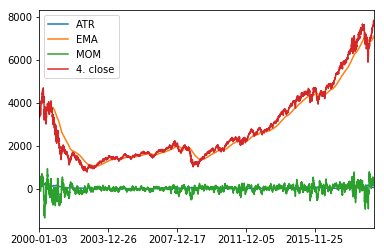

In [9]:
data.plot()
plt.show()

In [10]:
data['sp500'] = sp_500_data['4. close']
data['us_30'] = us_30_data['4. close']
print(data.head())

            ATR  EMA  MOM  4. close    sp500       us_30
2000-01-03  NaN  NaN  NaN    3791.0  1455.22  11357.5098
2000-01-04  NaN  NaN  NaN    3546.0  1399.42  10997.9297
2000-01-05  NaN  NaN  NaN    3507.0  1402.11  11122.6504
2000-01-06  NaN  NaN  NaN    3341.0  1403.45  11253.2598
2000-01-07  NaN  NaN  NaN    3530.0  1441.47  11522.5596


# Feature Engineering

## 1. Imputation

### - Filling all missing values with 0

In [ ]:
df = data.copy(deep=True)
df.fillna(0)
# Create two subplots sharing y axis
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharey=True)
plt.title('Data after filling missing values with 0')
ax1.plot(df['4. close'])
ax1.set(title='Nasdaq100 AdjClose Prices', xlabel='Price', ylabel='Date')

ax2.plot(df['sp500'])
ax2.set(title='s&p500 AdjClose Prices', xlabel='Price', ylabel='Date')

ax3.plot(df['us_30'])
ax3.set(title='us30 AdjClose Prices', xlabel='Price', ylabel='Date')

ax4.plot(tech_ind)
ax4.set(title='ATR (20) MOM (20) EMA (200)', ylabel='Date')

plt.show()

### - Filling missing values with median of the columns

In [ ]:
df1 = data.copy(deep=True)
df1.fillna(df.median)
# Create two subplots sharing y axis
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharey=True)
plt.title('Data after filling missing values with median of the columns')
ax1.plot(df1['4. close'])
ax1.set(title='Nasdaq100 AdjClose Prices', xlabel='Price', ylabel='Date')

ax2.plot(df1['sp500'])
ax2.set(title='s&p500 AdjClose Prices', xlabel='Price', ylabel='Date')

ax3.plot(df1['us_30'])
ax3.set(title='us30 AdjClose Prices', xlabel='Price', ylabel='Date')

ax4.plot(tech_ind)
ax4.set(title='ATR (20) MOM (20) EMA (200)', ylabel='Date')

plt.show()

## 2. Handling Outliers

- Outlier detection with standard deviation

In [ ]:
factor = 3
upper_lim = df['4. close'].mean() + df['4. close'].std() * factor
lower_lim = df['4. close'].mean() - df['4. close'].std() * factor

df = df[(df['4. close'] < upper_lim) & (df['4. close'] > lower_lim)]
df['4. close'].plot()
plt.title('Nasdaq Prices after dropping outliers with std')
plt.show()

-  Dropping outliers rows with Percentiles

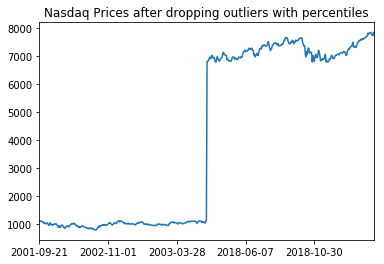

In [15]:
upper_lim = df['4. close'].quantile(.95)
lower_lim = df['4. close'].quantile(.05)

df = df[(df['4. close']< upper_lim) ^ (df['4. close'] > lower_lim)]
df['4. close'].plot()
plt.title('Nasdaq Prices after dropping outliers with percentiles')
plt.show()

## 3. Log Transform

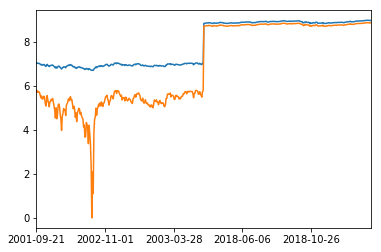

In [75]:
df['log+1'] = (df['4. close']+1).transform(np.log)
df['log'] = (df['4. close']-df['4. close'].min()+1).transform(np.log)
df['log+1'].plot()
df['log'].plot()
plt.show()

## 4. Scaling

c:\users\pkay\documents\programming\venvs\machine-learning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\pkay\documents\programming\venvs\machine-learning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


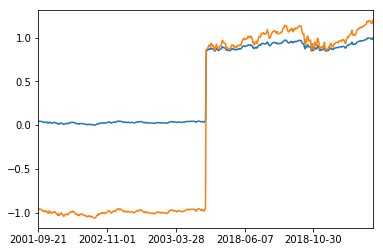

In [16]:
#  normalization
df['normalized'] = (df['4. close'] - df['4. close'].min()) / (df['4. close'].max() - df['4. close'].min())
#  standardization
df['standardized'] = (df['4. close'] - df['4. close'].mean()) / df['4. close'].std()
df['normalized'].plot()
df['standardized'].plot()
plt.show()

# Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
train_df = df[:300]
y = train_df['4. close']
X = train_df.drop('4. close', axis=1)
val_df = df[300:]
y_val = val_df['4. close']
X_val = val_df.drop('4. close', axis=1)

In [ ]:
model = svm.SVC(gamma='scale')  # Machine Learning Model

## 1. Hold out

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)

## 2. K-Fold

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
scores = cross_val_score(model, X_train, y_train,
 scoring=‘accurace’, cv=kf,
 n_jobs=1)
print(‘Folds: %i, mean squared error: %.2f std: %.2f’
 %(len(scores),np.mean(np.abs(scores)),np.std(scores)))

## 3. Leave One Out

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(model, X_train, y_train,
 scoring=‘accuracy’, cv=loo,
 n_jobs=1)
print(‘Folds: %i, mean squared error: %.2f std: %.2f’
 %(len(scores),np.mean(np.abs(scores)),np.std(scores)))